# loading data

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

# plotting and visualization

import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import sklearn.model_selection
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score,cross_validate
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

import pickle

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

import os

In [2]:
X_train = pd.read_csv("../Capstone_Two_Project/data/processed/X_train.csv", index_col = 0)
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_SO2_ratio,alcohol_surgar_ratio,sugar_acidity_ratio,fixed_acidity_ratio
0,0.247934,0.120000,0.192771,0.098160,0.053156,0.128472,0.258065,0.130904,0.410853,0.168539,0.405797,0.358702,0.078052,0.124245,0.839710
1,0.239669,0.113333,0.445783,0.288344,0.074751,0.149306,0.375576,0.256217,0.612403,0.129213,0.260870,0.284783,0.018717,0.366162,0.845020
2,0.190083,0.213333,0.096386,0.018405,0.099668,0.034722,0.043779,0.161751,0.542636,0.292135,0.304348,0.500078,0.310672,0.028200,0.686411
3,0.231405,0.126667,0.150602,0.038344,0.071429,0.138889,0.419355,0.084635,0.403101,0.101124,0.478261,0.234125,0.198261,0.051629,0.824361
4,0.165289,0.086667,0.192771,0.015337,0.059801,0.128472,0.205069,0.045306,0.395349,0.404494,0.637681,0.452140,0.432972,0.026762,0.851406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6031,0.232797,0.065614,0.227901,0.014062,0.037087,0.091411,0.240359,0.082382,0.416075,0.189178,0.497635,0.269405,0.421025,0.020978,0.905414
6032,0.292554,0.133367,0.201169,0.090634,0.024262,0.054529,0.219156,0.127660,0.200748,0.176455,0.373884,0.167985,0.083460,0.105738,0.839941
6033,0.300610,0.162201,0.197012,0.086024,0.037714,0.043268,0.278422,0.099410,0.337849,0.107232,0.603911,0.099637,0.102145,0.098697,0.810163
6034,0.213175,0.207843,0.125620,0.037667,0.040551,0.086602,0.247697,0.056601,0.368446,0.171679,0.684143,0.248503,0.230315,0.051596,0.709345


In [3]:
X_test = pd.read_csv("../Capstone_Two_Project/data/processed/X_test.csv", index_col = 0)

In [4]:
y_train = pd.read_csv("../Capstone_Two_Project/data/processed/y_train.csv",index_col = False)

y_train=y_train.drop('Unnamed: 0',axis=1)

In [5]:
y_test = pd.read_csv("../Capstone_Two_Project/data/processed/y_test.csv", index_col = False)
y_test=y_test.drop('Unnamed: 0',axis=1)

# Modeling

## Metrics for model performance

For a classification machine learning, several metrics such as accuracy, recall, F1 and ROC_AUC are used in model performance evaluation. The project purpose is to predict good quality wine, and the dataset is imblanced, therefore the model with highest recall values with relative high scores in other metrics such as ROC_auc, Accuracy among the three models:Logisticregression, randomforest, XGBoost will be the winner. 

## Baseline model

dummyclassifier is used in modeling prediction. it will serve as the baseline modeling, good models should shows better metris than it.

In [6]:
dummy = DummyClassifier(strategy ="stratified",random_state = 123)
dummy.fit(X_train.values,y_train.values.ravel())
y_pred = dummy.predict(X_test.values)
y_pred_probs = dummy.predict_proba(X_test.values) [:,1]
roc_auc_score_dummy = roc_auc_score(y_test, y_pred_probs)
print(roc_auc_score_dummy)


0.47562273628754986


dummy: recall=0.480
report:               precision    recall  f1-score   support

           0       0.79      0.48      0.60      1293
           1       0.18      0.47      0.25       303

    accuracy                           0.48      1596
   macro avg       0.48      0.48      0.43      1596
weighted avg       0.68      0.48      0.53      1596
 



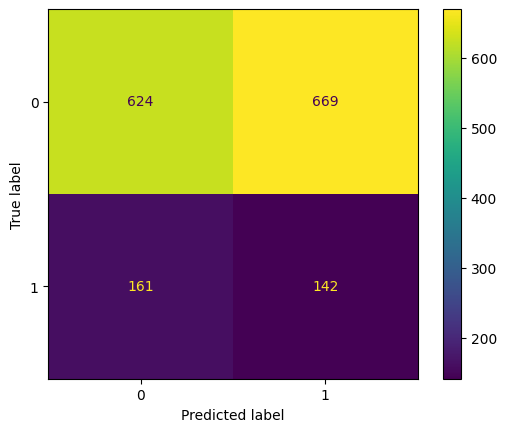

In [7]:
pc_dummy = recall_score(y_test, y_pred_probs,average='weighted')
report_dummy = classification_report(y_test, y_pred)
cm_dummy = confusion_matrix(y_test, y_pred)
print('dummy: recall=%.3f' % (pc_dummy))
print("report:", report_dummy,"\n")
ConfusionMatrixDisplay(confusion_matrix=cm_dummy,display_labels=dummy.classes_).plot()
plt.show()

In dummy model, the recall for predict good win is 0.48.

three models:logisticregression, random forest and XGBoost Model will be selected. Also, the number of features used in modeling was controlled by selectkbest algorithms. 

## Logisticregression model

In [8]:
from sklearn.pipeline import Pipeline
pipe_log = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression, k =5)),("model",
    LogisticRegression())]
)

In [9]:
#k = [k+1 for k in range(len(X_train.columns))]
c_values = [0.01,0.1,1.0,10,100]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
grid_params = {'model__C':c_values,'model__solver':solvers}
#grid_params = {'feature_selection__k': k, 'model__C':c_values,'model__solver':solvers}
#grid_params = {'feature_slection__k': k}

In [10]:
log_grid_cv = GridSearchCV(pipe_log, param_grid=grid_params,scoring="recall", cv=5, n_jobs=-1)
log_grid_cv.fit(X_train, y_train.values.ravel())
score_mean = log_grid_cv.cv_results_['mean_test_score']
score_std = log_grid_cv.cv_results_['std_test_score']
log_grid_cv.best_params_

{'model__C': 0.01, 'model__solver': 'liblinear'}

In [11]:
selected = log_grid_cv.best_estimator_.named_steps.feature_selection.get_support()
coefs = log_grid_cv.best_estimator_.named_steps.model.coef_
features = X_train.columns[selected]
pd.Series(coefs.ravel(), index = features.ravel()).sort_values(ascending=False)

alcohol                1.675378
fixed_acidity_ratio    0.097825
chlorides             -0.327597
density               -0.514166
volatile_acidity      -0.623222
dtype: float64

it shows the alcohol is critical in control wine quality.

In [12]:
cv_log = cross_validate(log_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='recall', cv=5, n_jobs=-1)
cv_scores_log = cv_log['test_score']
np.mean(cv_scores_log), np.std(cv_scores_log)

(0.8154514403698945, 0.015151840976826265)

In [13]:
y_tr_pred = log_grid_cv.best_estimator_.predict(X_train)
y_te_pred = log_grid_cv.best_estimator_.predict(X_test)
y_pred_probs = log_grid_cv.best_estimator_.predict_proba(X_test.values) [:,1]
#print(roc_auc_score(y_test, y_pred_probs))

C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%.2f' % (best_thresh))

Best Threshold=0.50


In [15]:
y_pred = (y_pred_probs >= 0.50).astype('int')
print("logisticregression roc_auc:%.2f"% roc_auc_score(y_test, y_pred))
print("logisticregression precision:%.2f"%  precision_score(y_test, y_pred))
print("logisticregression recall:%.2f"% recall_score(y_test, y_pred))
print("logisticregression accuracy:%.2f"% accuracy_score(y_test, y_pred))

logisticregression roc_auc:0.75
logisticregression precision:0.38
logisticregression recall:0.80
logisticregression accuracy:0.72


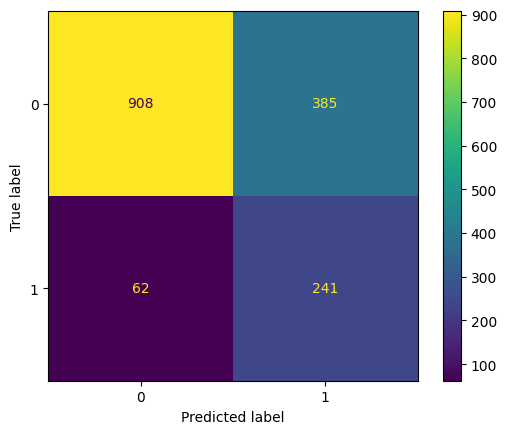

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1293
           1       0.38      0.80      0.52       303

    accuracy                           0.72      1596
   macro avg       0.66      0.75      0.66      1596
weighted avg       0.83      0.72      0.75      1596



In [16]:
report_log = classification_report(y_test, y_pred)
cm_log = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_log,
                       display_labels=log_grid_cv.classes_).plot()
plt.show()
print(classification_report(y_test, y_pred))

## Random forest 

In [17]:
pipe_rf = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression,k=5)),("rf",
    RandomForestClassifier(random_state= 123))]
)

In [18]:
pipe = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression,k=5)),("rf",
    RandomForestClassifier(random_state= 123))]
)

#k = [k+1 for k in range(len(X_train.columns))]
n_est = [50,100,300,500]
grid_params = {'rf__n_estimators': n_est}

# grid_params = {'feature_selection__k': k,
#         'rf__n_estimators': n_est
# }

rf_grid_cv = GridSearchCV(pipe, param_grid=grid_params,scoring ="recall", cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train.values.ravel())
rf_grid_cv.best_params_

{'rf__n_estimators': 500}

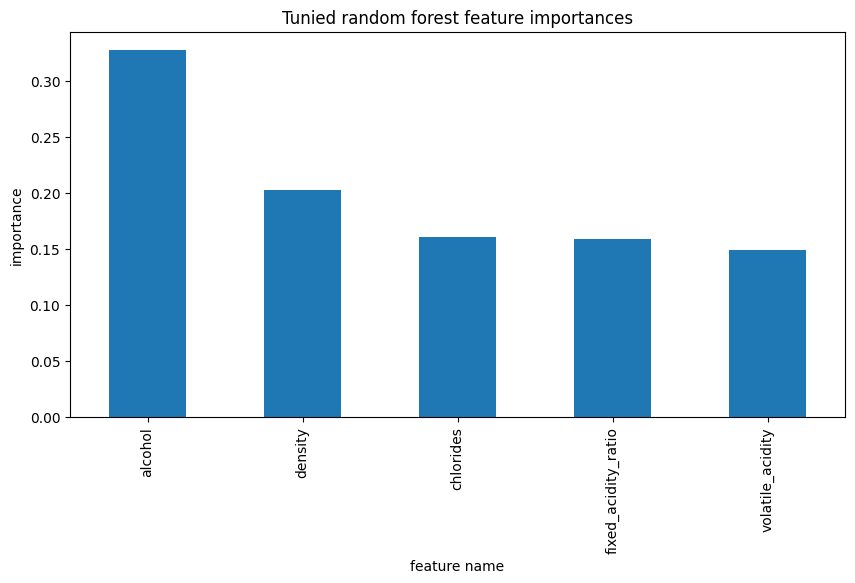

In [19]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 

features_imp = rf_grid_cv.best_estimator_.named_steps.rf.feature_importances_

feature_names =  rf_grid_cv.best_estimator_.named_steps.feature_selection.get_feature_names_out()

plt.subplots(figsize=(10, 5))
rf_feat = pd.Series(features_imp, index=feature_names).sort_values(ascending=False)
rf_feat.plot(kind='bar')
plt.xlabel('feature name')
plt.ylabel('importance')
plt.title('Tunied random forest feature importances');

Similar to logistic regression, the alcohol level has high impact on producting high wine quality.

In [20]:
cv_rf = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='recall', cv=5, n_jobs=-1)
cv_scores_rf = cv_rf['test_score']
np.mean(cv_scores_rf), np.std(cv_scores_rf)

(0.8959754209087014, 0.05732580184926192)

In [21]:
y_tr_pred = rf_grid_cv.best_estimator_.predict(X_train)
y_te_pred = rf_grid_cv.best_estimator_.predict(X_test)
y_pred_probs = rf_grid_cv.best_estimator_.predict_proba(X_test.values) [:,1]
#print(roc_auc_score(y_test, y_pred_probs))

C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [22]:
# # get the best threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%.2f' % (best_thresh))

Best Threshold=0.28


In [23]:
y_pred = (y_pred_probs >= 0.28).astype('int')
print("randomforest roc_auc:%.2f"%roc_auc_score(y_test, y_pred))
print("randomforest precision:%.2f"% precision_score(y_test, y_pred))
print("randomforest recall:%.2f"% recall_score(y_test, y_pred))
print("randomforest Accuracy:%.2f"% accuracy_score(y_test, y_pred))

randomforest roc_auc:0.73
randomforest precision:0.35
randomforest recall:0.81
randomforest Accuracy:0.68


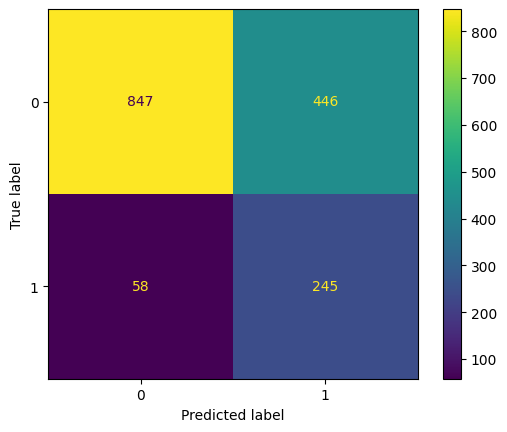

              precision    recall  f1-score   support

           0       0.94      0.66      0.77      1293
           1       0.35      0.81      0.49       303

    accuracy                           0.68      1596
   macro avg       0.65      0.73      0.63      1596
weighted avg       0.83      0.68      0.72      1596



In [24]:
report_rf = classification_report(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                       display_labels=rf_grid_cv.classes_).plot()
plt.show()
print(classification_report(y_test, y_pred))

## XGBoost model

In [25]:
pipe_xgb = Pipeline(
    steps =[("feature_selection",SelectKBest(score_func=f_regression,k=5)),("xgb",
    XGBClassifier(objective='binary:logistic',learning_rate=0.1 , n_estimators=300, random_state=123))]
)

### xgb model tunning

In [26]:
gbm_param_grid = {
   'xgb__learning_rate' : np.arange(0.05, 1,0.05),
    'xgb__max_depth': np.arange(3, 10, 1),
    'xgb__n_estimators': np.arange(50,200, 50)
}


In [27]:
from sklearn.model_selection import RandomizedSearchCV
xgb_randomized_cv = RandomizedSearchCV(pipe_xgb,gbm_param_grid,n_iter=2,scoring='recall',cv=5,verbose=1)
xgb_randomized_cv.fit(X_train, y_train.values.ravel())


Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_selection',
                                              SelectKBest(k=5,
                                                          score_func=<function f_regression at 0x000002C233B344C0>)),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric...
                                                            multi_strategy=None,
                                                            n_estimators=300,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=123, ...))]),
                   n_iter=2,
                   param_distributions={'xgb__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'xgb__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'xgb__n_estimators': array([ 50, 100, 150])},
                   scoring='recall', verbose=1)

In [28]:
xgb_randomized_cv.best_params_

{'xgb__n_estimators': 50,
 'xgb__max_depth': 9,
 'xgb__learning_rate': 0.9000000000000001}

In [29]:
xgb_features_imp =xgb_randomized_cv.best_estimator_.named_steps["xgb"].feature_importances_
feature_names = xgb_randomized_cv.best_estimator_.named_steps.feature_selection.get_feature_names_out()

<Axes: title={'center': 'xgb model feature importance'}, xlabel='feature important ratio', ylabel='Feature'>

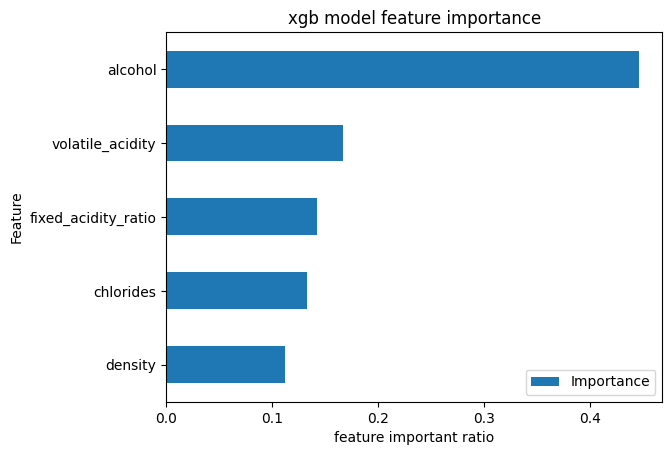

In [30]:
# making a pandas dataframe
data = list(zip(feature_names, xgb_features_imp))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance'
                                             ]).sort_values(by='Importance')
df_importances.plot.barh(x='Feature',
                         y='Importance',
                         xlabel="feature important ratio",
                         title="xgb model feature importance")

In [31]:
cv_xgb= cross_validate(xgb_randomized_cv.best_estimator_, X_train, y_train, 
                            scoring='recall', cv=5, n_jobs=-1)

cv_scores_xgb = cv_xgb['test_score']
np.mean(cv_scores_xgb), np.std(cv_scores_xgb)

(0.8410035913149484, 0.16804772117553912)

In [32]:
y_tr_pred = xgb_randomized_cv.best_estimator_.predict(X_train)
y_te_pred = xgb_randomized_cv.best_estimator_.predict(X_test)
y_pred_probs = xgb_randomized_cv.best_estimator_.predict_proba(
    X_test.values)[:, 1]
#print(roc_auc_score(y_test, y_pred_probs))

C:\Users\Yan Zhang\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [33]:

# # get the best threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%.2f' % (best_thresh))

Best Threshold=0.14


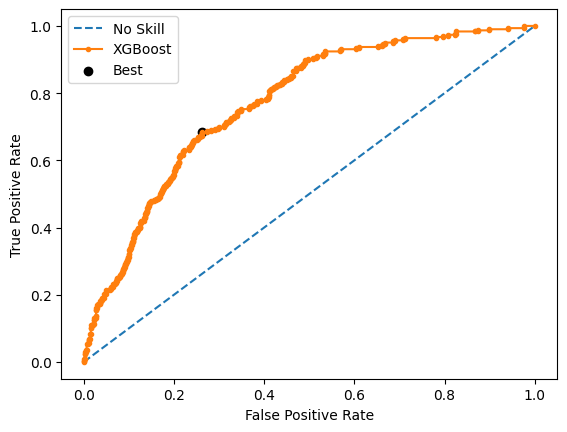

In [34]:

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [42]:
y_pred = (y_pred_probs >= 0.14).astype('int')

In [43]:
print("XGBOOST roc_auc:%.2f"% roc_auc_score(y_test, y_pred))
print("XGBOOST precision:%.2f"%  precision_score(y_test, y_pred))
print("XGBOOST recall:%.2f"% recall_score(y_test, y_pred))
print("XGBOOST Accuracy:%.2f"% accuracy_score(y_test, y_pred))

XGBOOST roc_auc:0.71
XGBOOST precision:0.38
XGBOOST recall:0.67
XGBOOST Accuracy:0.73


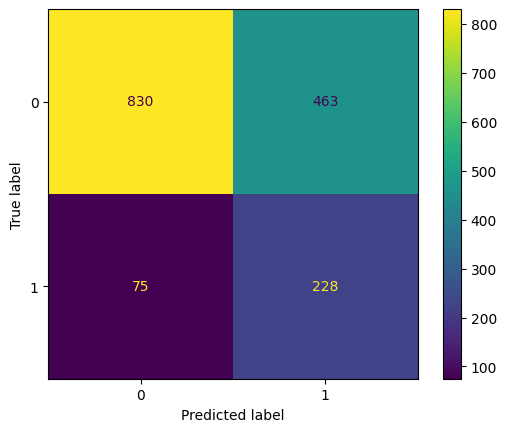

              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1293
           1       0.33      0.75      0.46       303

    accuracy                           0.66      1596
   macro avg       0.62      0.70      0.61      1596
weighted avg       0.81      0.66      0.70      1596



In [37]:
report_xgb = classification_report(y_test, y_pred)
cm_xgb = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_xgb,display_labels=xgb_randomized_cv.classes_).plot()
plt.show()
print(classification_report(y_test, y_pred))

In [44]:

model_1_metrics = {"cv score":0.82,"roc_auc":0.75,"precision":0.38, "recall":0.80,"accuracy":0.72}
model_2_metrics = {"cv score":0.90,"roc_auc":0.73,"precision":0.35, "recall":0.81,"accuracy":0.68}
model_3_metrics = {"cv score":0.84,"roc_auc":0.71,"precision":0.33, "recall":0.67,"accuracy":0.73}
all_metrics=[model_1_metrics,model_2_metrics,model_3_metrics]
model_names =["LogisticRegression","Randomforest","XGBoost"]
metrics_df = pd.DataFrame(all_metrics, index =model_names )
metrics_df

,cv score,roc_auc,precision,recall,accuracy
LogisticRegression,0.82,0.75,0.38,0.80,0.72
Randomforest,0.90,0.73,0.35,0.81,0.68
XGBoost,0.84,0.71,0.33,0.67,0.73


among the three models, the random forest showed the highest cross validation score 0.90 and recall score (0.81) and it be selected as the final model

## Save best model object frome pipeline

In [45]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()


In [46]:
import pickle

In [47]:
# save the model to disk
filename = 'wine_quality_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

## summary

Four modeling were performed in good wine quality prediction. At beginner, the dummyclassifier is used as baseline model, which the prediction is irrelavent to featrues. Then three models logisticregression, random forest model and xgboost were evaluate through pipeline. the cv results shows the random forest model have highest scores. All three model were tunning, and the metrics such as precision, recall, f1 and roc_auc scores were recorded. In the end, the random forest had highest recall score (0.81), and be chose as the final model. 


## future work

1. in the modeling, only five feature were used, may try more features to feed a model.
2. in the data preprocess, the outliners was not removed, it may affect the model performance. If time allowed, will address the outliners before modeling.
3. the modeling reveals alcohol play important role in producing good wine quality, the relation of alcohol amount to quality need to further explored. 